# Neighborhoods question
Q (from a meeting agenda Bloomberg_ Gun Violence Dashboard_ Meeting 2 Agenda.docx): 
```
Final Neighborhood Questions:
1. Not duplicating MSU Project Green Light (PGL) study, what new can we learn from PGL data that give insight to where interventions should be targeted?
2. Are there specific locations/ property types that become magnets for gun violence incidents?
3. What can we find unique to areas/ blocks where we see highest event rates (presence of empty lots, convenience stores, gas stations, bus stops, schools, etc)?
```

If we're looking to identify where interventions should be targeted... Detroit has the gun violence rates, so the clearly correct thing to do is target interventions where gun violence rates are high.

Another way of viewing this question is to inform policy choices (change characteristics based on correlations and hope it's causal). This would require _way_ more work than we have time for

In [1]:
import geopandas as gpd

from features.income import Income
from features.violence_calls import ViolenceCalls
from features.households import Households
from features.household_types_ages import HouseholdTypesAges
from features.household_types import HouseholdTypes
from features.population import Population
from features.population_density import PopulationDensity
from features.feature_constructor import Feature
from features.out_of_state_rental_ownership import OutOfStateRentalOwnership
from features.ddot_bus_stops import DDotBusStops
from features.smart_bus_stops import SmartBusStops
from features.rental_statuses import RentalStatuses
from features.project_green_light_locations import ProjectGreenlightLocations
from util_detroit import concatenate_features

from detroit_geos import get_detroit_census_geos, get_detroit_boundaries

import patsy
from patsy import dmatrices, dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.impute import SimpleImputer
import matplotlib as mpl

In [2]:
# Fetch geometries for visualization

tracts = get_detroit_census_geos(decennial_census_year=2010,target_geo_grain='tract',).set_index('geo_id')
detroit = get_detroit_boundaries()
block = get_detroit_census_geos(decennial_census_year=2010,target_geo_grain='block').set_index('geo_id')

# Build Features

In [17]:
target_geo_grain = "tract"
feature_objects = [
    Population(
        decennial_census_year=2010, population_data_path="population", verbose=False
    ),
    PopulationDensity(
        decennial_census_year=2010,
        population_data_path="population",
    ),
    ViolenceCalls(decennial_census_year=2010, verbose=False),
    Income(verbose=False),
    Households(),
    OutOfStateRentalOwnership(2010),
    DDotBusStops(decennial_census_year=2010),
    SmartBusStops(decennial_census_year=2010),
    RentalStatuses(decennial_census_year=2010),
    ProjectGreenlightLocations(decennial_census_year=2010),
]
feat_df = concatenate_features(feature_objects,'tract')

# Transform

In [256]:
from munge_features import transform_1
from constants import COLNAME_MAP
from sklearn.preprocessing import StandardScaler
df, df0 = transform_1(feat_df)

# df = pd.DataFrame(StandardScaler().fit_transform(df),index=df.index,columns=df.columns)

# fig, ax = plt.subplots(1,1,figsize=(20,20))
# df.hist(ax=ax,bins=20)

In [87]:
formula_bones = "call_rate ~ " + '\n+ '.join([x for x in df.columns if ('call_rate' not in x)])
formula = formula_bones#.replace('per_household_income','np.log(per_household_income)')
y, X = dmatrices(
    formula_like=formula,
    data=df,
    return_type="dataframe",
)
# convert to events per 1000 people per year
y = y/4.5*1000
# D = dmatrix(
#     formula_like=formula.replace('~','+'),
#     data=df,
#     return_type="dataframe",
# )

# r2 = (D.corr()**2).call_rate.sort_values()

# Run regressions

In [125]:
XX = patsy.standardize(X).assign(Intercept=1).astype(float)
mdl = sm.OLS(endog=y,exog=XX)
res = mdl.fit()
res.summary()

# res.params

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              call_rate   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     17.76
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           4.60e-22
Time:                        15:12:29   Log-Likelihood:                -1923.8
No. Observations:                 341   AIC:                             3866.
Df Residuals:                     332   BIC:                             3900.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       104.7378      3.744     27.972      0.000      97.372     112.104
population_density              -16.5394      4.415     -3.746      0.000     -25.224      -7.854
per_household_income             -4.1255      5.166     -0.799      0.425     -14.287       6.036
out_of_state_rental_ownership     7.1537      3.921      1.824      0.069      -0.560      14.867
married_household_prop          -19.4659      5.366     -3.628      0.000     -30.021      -8.910
greenlight_density                8.0632      4.763      1.693      0.091      -1.306      17.432
people_per_household              2.2612      4.238      0.533      0.594      -6.076      10.599
rental_density                    9.8055      6.070      1.615      0.107      -2.135      21.746
bus_density                      11.4327      5.739      1.992      0.047       0.144      22.722
==============================================================================
Omnibus:                      517.946   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           127236.242
Skew:                           7.738   Prob(JB):                         0.00
Kurtosis:                      96.357   Cond. No.                         3.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [155]:
XX = patsy.standardize(X).assign(Intercept=1).astype(float)
mdl = sm.OLS(endog=y,exog=XX)
res = mdl.fit_regularized(method='elastic_net',L1_wt = 1,alpha=10,refit=False,zero_tol=.0001)
XXX = XX.drop(columns=res.params[res.params==0].index)
mdl = sm.OLS(endog=y,exog=XXX)

res = mdl.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              call_rate   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     33.75
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           1.12e-23
Time:                        15:18:36   Log-Likelihood:                -1927.0
No. Observations:                 341   AIC:                             3864.
Df Residuals:                     336   BIC:                             3883.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                104.7378      3.757     27.880      0.000      97.348     112.127
population_density       -14.4355      4.301     -3.356      0.001     -22.896      -5.975
married_household_prop   -21.6365      4.305     -5.026      0.000     -30.104     -13.169
rental_density            12.9060      5.687      2.270      0.024       1.720      24.092
bus_density               14.5333      5.437      2.673      0.008       3.838      25.228
==============================================================================
Omnibus:                      516.865   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           126621.696
Skew:                           7.707   Prob(JB):                         0.00
Kurtosis:                      96.135   Cond. No.                         2.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

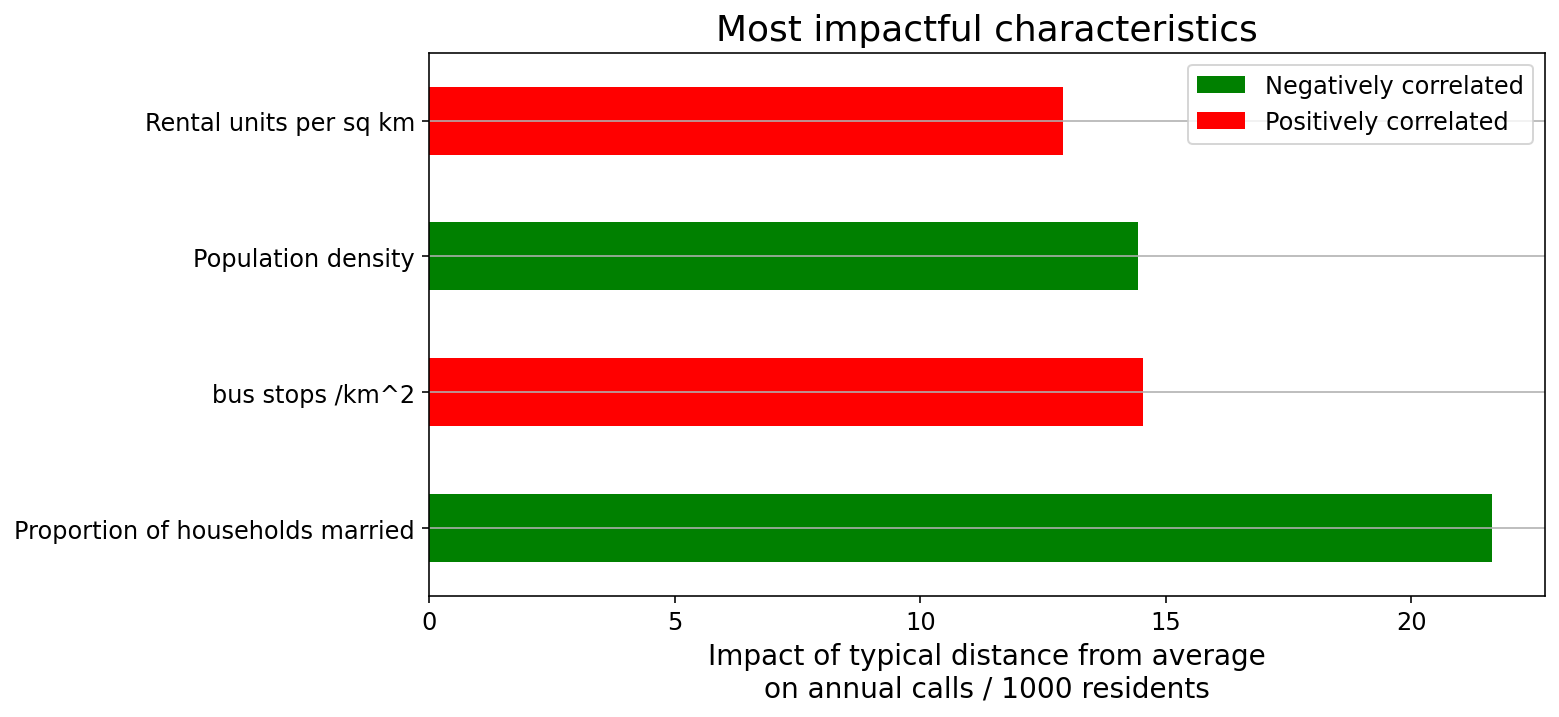

In [217]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sorted_abs_params = res.params.drop('Intercept').abs().sort_values(ascending=False)

tt = sorted_abs_params.rename(COLNAME_MAP).plot(kind='barh',ax=ax,color=['r' if x else 'g' for x in (res.params.loc[sorted_abs_params.index]>0)])
ax.grid(True, axis='y')
_ = ax.set(xlabel='Impact of typical distance from average\non annual calls / 1000 residents',title='Most impactful characteristics')
ax.legend([x for x in tt.get_children() if isinstance(x,mpl.patches.Rectangle)],['Negatively correlated','Positively correlated'])

In [218]:
most_calls = y.sort_values('call_rate').index[-5:]
XXX.loc[most_calls]

,Intercept,population_density,married_household_prop,rental_density,bus_density
tract,,,,,
2.616355e+10,1.0,-1.635811,-0.660678,1.183757,0.608088
2.616350e+10,1.0,-0.578244,0.194290,0.733278,0.344475
2.616399e+10,1.0,-2.171613,-0.450019,-0.629715,1.931999
2.616352e+10,1.0,-1.524940,-0.791056,-0.598063,1.487856
2.616398e+10,1.0,-2.151180,-0.290532,-1.977952,-0.174244


In [259]:
df0.loc[most_calls]

,population_density,per_household_income,out_of_state_rental_ownership,call_rate,married_household_prop,people_per_household,greenlight_density,rental_density,bus_density
tract,,,,,,,,,
2.616355e+10,316.771881,26130.0,0.007463,326.590443,0.119840,1.009321,2.392889,320.647147,45.464894
2.616350e+10,896.754399,41312.0,0.269841,380.682134,0.245025,2.483831,0.000000,140.295938,33.403795
2.616399e+10,22.931242,45320.0,1.000000,383.017164,0.150685,0.842466,5.363861,10.727722,209.190587
2.616352e+10,377.574986,81669.0,0.000000,541.956421,0.100750,1.541265,102.829905,11.425545,125.680995
2.616398e+10,34.136901,40003.0,0.222222,1030.303030,NaN,5.000000,0.000000,0.000000,18.044989


In [225]:
contributions = (XXX.loc[most_calls]*res.params).drop(columns=['Intercept'])
contributions

,population_density,married_household_prop,rental_density,bus_density
tract,,,,
2.616355e+10,23.613727,14.294789,15.277554,8.837505
2.616350e+10,8.347240,-4.203776,9.463683,5.006352
2.616399e+10,31.348296,9.736859,-8.127098,28.078261
2.616352e+10,22.013248,17.115715,-7.718593,21.623414
2.616398e+10,31.053337,6.286105,-25.527435,-2.532332


In [255]:
df.loc[most_calls]

,population_density,per_household_income,out_of_state_rental_ownership,call_rate,married_household_prop,greenlight_density,people_per_household,rental_density,bus_density
tract,,,,,,,,,
2.616355e+10,316.771881,10.170839,0.007463,326.590443,0.119840,1.221682,1.009321,5.773455,3.838697
2.616350e+10,896.754399,10.628908,0.269841,380.682134,0.245025,0.000000,2.483831,4.950857,3.538167
2.616399e+10,22.931242,10.721504,1.000000,383.017164,0.150685,1.850635,0.842466,2.461955,5.348015
2.616352e+10,377.574986,11.310430,0.000000,541.956421,0.100750,4.642754,1.541265,2.519754,4.841672
2.616398e+10,34.136901,10.596710,0.222222,1030.303030,0.174037,0.000000,5.000000,0.000000,2.946804


In [264]:
most_calls[0]

26163545400.0

In [284]:
res.params

Intercept                 104.737806
population_density        -14.435487
married_household_prop    -21.636549
rental_density             12.905992
bus_density                14.533272
dtype: float64

In [287]:
df0.loc[most_calls[0]]

population_density                 316.771881
per_household_income             26130.000000
out_of_state_rental_ownership        0.007463
call_rate                          326.590443
married_household_prop               0.119840
people_per_household                 1.009321
greenlight_density                   2.392889
rental_density                     320.647147
bus_density                         45.464894
Name: 26163545400.0, dtype: float64

In [285]:
s.sum()+res.params.Intercept

166.76138259879588

In [299]:
import plotly.graph_objects as go
# fig, ax = plt.subplots(1,1,figsize=(6,4))
s = contributions.iloc[0, :]
fig = go.Figure(
    go.Waterfall(
        name="Annual calls per 1k residents",
        orientation="v",
        #     measure = ['total'] + (XXX.shape[1]-1)*['relative'],
        x=contributions.rename(columns=COLNAME_MAP).columns,
        textposition="outside",
        #     text = ["+60", "+80", "", "-40", "-20", "Total"],
        y=s.values,
        connector={"line": {"color": "rgb(63, 63, 63)"}},
#         ax=ax
    )
)

fig.update_layout(font=dict(size=20),yaxis_title='Impact on annual calls per capita',title=f"Contributors for tract {int(most_calls[0])}", showlegend=False)
        
# plt.gca().set(ylabel='Associated Impact on annual violent events per capita')

In [301]:
res.params

Intercept                 104.737806
population_density        -14.435487
married_household_prop    -21.636549
rental_density             12.905992
bus_density                14.533272
dtype: float64

In [311]:
cols_to_log=["greenlight_density", "rental_density", "bus_density", "per_household_income"]

In [321]:
np.logspace(min(df0_slim.loc[:,c]),num=20)

TypeError: _logspace_dispatcher() missing 1 required positional argument: 'stop'

In [324]:
df0_slim

,population_density,married_household_prop,rental_density,bus_density
tract,,,,
2.616350e+10,1824.898354,0.173157,419.793244,28.722696
2.616350e+10,1856.991606,0.174632,158.882786,27.631789
2.616350e+10,1329.122055,0.075216,179.375550,40.123478
2.616350e+10,917.210175,0.120000,14.513576,41.726532
2.616350e+10,1476.359684,0.120553,73.183386,28.377231
...,...,...,...,...
2.616358e+10,1005.423452,0.203540,0.000000,0.000000
2.616358e+10,316.470057,0.439142,0.000000,0.000000
2.616398e+10,34.136901,NaN,0.000000,18.044989


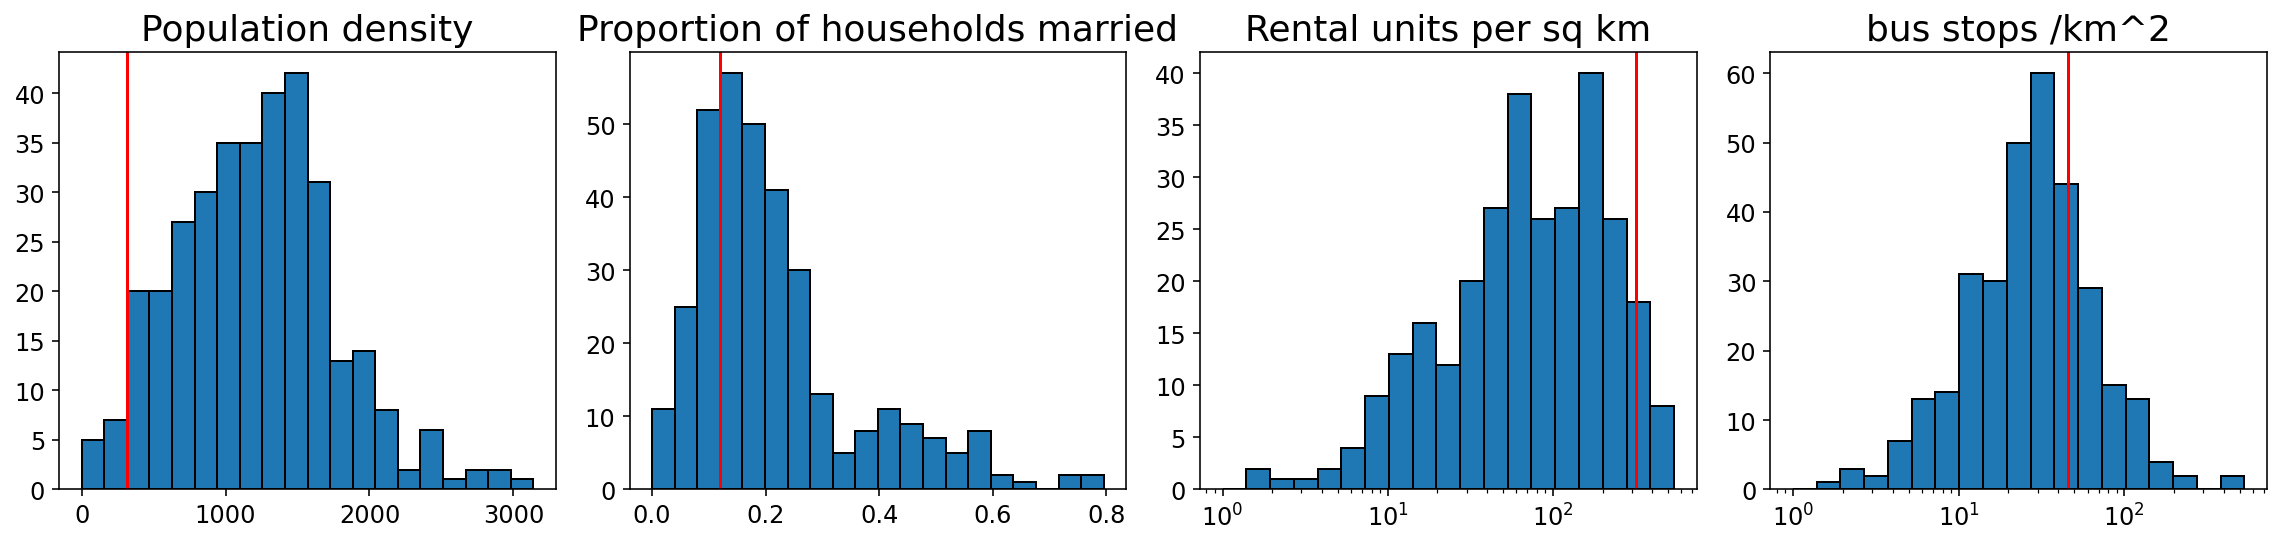

In [335]:
cols = res.params.drop('Intercept').index
df0_slim = df0.copy().loc[:,cols]
fig, ax = plt.subplots(1,4,figsize=(16,4))
for i, c in enumerate(cols):
    if c in cols_to_log:
        bins = np.geomspace(df0_slim.loc[:,c].min()+1,df0_slim.loc[:,c].max()+12,num=20)
        ax[i].set(xscale='log')
    else:
        bins = 20
    ax[i].hist(df0_slim.loc[:,c],bins=bins,edgecolor='k')
    ax[i].set(title=COLNAME_MAP[c])
    ax[i].axvline(x=df0_slim.loc[most_calls[0],c],color='r')
#     
#         ax[i].set(xscale='log')
plt.tight_layout()

    


In [280]:
type(fig)

plotly.graph_objs._figure.Figure

In [46]:
# formula = (
#     formula_bones.replace("per_household_income", "np.log(per_household_income)")
#     .replace("rental_density", "np.log(rental_density+1)")
#     .replace("bus_density", "np.log(bus_density+1)")
# )
formula = formula_bones

y, X = dmatrices(
    formula_like=formula,
    data=df,
    return_type="dataframe",
)

mdl = sm.OLS(endog=y, exog=X)
res = mdl.fit()
res.summary()

# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# X.hist(ax=ax)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              call_rate   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     17.76
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           4.60e-22
Time:                        14:41:00   Log-Likelihood:                -423.12
No. Observations:                 341   AIC:                             864.2
Df Residuals:                     332   BIC:                             898.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      1.691e-17      0.046   3.68e-16      1.000      -0.090       0.090
population_density               -0.2029      0.054     -3.746      0.000      -0.309      -0.096
per_household_income             -0.0506      0.063     -0.799      0.425      -0.175       0.074
out_of_state_rental_ownership     0.0877      0.048      1.824      0.069      -0.007       0.182
married_household_prop           -0.2388      0.066     -3.628      0.000      -0.368      -0.109
greenlight_density                0.0989      0.058      1.693      0.091      -0.016       0.214
people_per_household              0.0277      0.052      0.533      0.594      -0.075       0.130
rental_density                    0.1203      0.074      1.615      0.107      -0.026       0.267
bus_density                       0.1402      0.070      1.992      0.047       0.002       0.279
==============================================================================
Omnibus:                      517.946   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           127236.242
Skew:                           7.738   Prob(JB):                         0.00
Kurtosis:                      96.357   Cond. No.                         3.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
y, X = dmatrices(
    formula_like=formula,
    data=df,
    return_type="dataframe",
)
# exposure = X.pop('population')
mdl = sm.GLM(endog=y,exog=X,family=sm.families.Poisson())
res = mdl.fit()

res.summary()
res = mdl.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              call_rate   No. Observations:                  341
Model:                            GLM   Df Residuals:                      332
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -242.69
Date:                Tue, 08 Mar 2022   Deviance:                       52.806
Time:                        16:36:22   Pearson chi2:                     60.9
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08364
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.4649      3.308      0.141      0.888      -6.018       6.948
population_density               -0.0003      0.000     -1.761      0.078      -0.001    3.59e-05
np.log(per_household_income)     -0.0715      0.311     -0.230      0.818      -0.682       0.539
out_of_state_rental_ownership     0.7246      0.596      1.216      0.224      -0.444       1.893
married_household_prop           -2.8160      0.945     -2.981      0.003      -4.667      -0.965
rental_density                    0.0010      0.001      1.292      0.196      -0.001       0.002
bus_density                      -0.0002      0.002     -0.116      0.907      -0.003       0.003
greenlight_density                0.0053      0.005      1.153      0.249      -0.004       0.014
people_per_household              0.0515      0.106      0.488      0.626      -0.155       0.258
=================================================================================================
"""

# Compare impact of granularity

In [13]:
mdl = {}
res = {}
for target_geo_grain in ("block","block group","tract"):
    feat_df = concatenate_features(feature_objects,target_geo_grain)
    df = transform_1(feat_df)
    y, X = dmatrices(
        formula_like=formula,
        data=df,
        return_type="dataframe",
    )
    mdl[target_geo_grain] = sm.OLS(endog=y,exog=X)
    res[target_geo_grain] = mdl[target_geo_grain].fit()
    res[target_geo_grain].summary()

You may want to rerun self.cache_features()
You may want to rerun self.cache_features()
You may want to rerun self.cache_features()


In [14]:
res['block group'].conf_int()

,0,1
Intercept,0.967753,2.730049
population_density,-0.000125,-0.000046
np.log(per_household_income),-0.196128,-0.028101
out_of_state_rental_ownership,0.097762,0.352427
married_household_prop,-0.838216,-0.411278
rental_density,-0.000583,0.001865
bus_density,0.000696,0.004982
greenlight_density,0.018573,0.034731
people_per_household,-0.074605,0.004508


In [46]:
l = [pd.concat((res[g].conf_int().rename(columns={0:.025,1:.975}),res[g].params.rename(0.5)),axis=1) for g in ("block","block group","tract")]

grains = ("block","block group","tract")

tt = pd.concat(l,keys=grains).loc[:,[.025,.500,.975]].assign(y=np.nan)

for i, g in enumerate(grains):
    tt.loc[g,'y'] = np.zeros(tt.loc[g,'y'].shape[0])+.2*i

fig, ax = plt.subplots(9,1,figsize=(8,30))
for _, sub_df in tt.groupby(level=0):
    i = 0
    for name, sdf in sub_df.reset_index(level=1).melt(id_vars=['y','level_1']).sort_values(['level_1','y']).groupby('level_1'):
        sdf.plot(x='value',y='y',ax=ax[i],marker='o',legend=False,title=name)
        ax[i].legend(grains)
        i+=1
plt.tight_layout()